# This notebook regroups all the code around graph formation/cost prescription estimation (AKM estimator using pytwoway and another estimation using Linear Regression)

This a notebook has been initially written by Arthur Sabre and has been thereafter improved by Vincent Gimenes

## Packages and Import

Python version used for pytwoway : 3.10 (3.10.12 or 3.10.13 is fine)

In [2]:
#!pip install pytwoway
#!pip install seaborn
#!pip install pytwoway

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pytwoway as tw
import bipartitepandas as bpd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import time
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning) # Useful for logistic regression
pd.options.mode.chained_assignment = None  # default='warn' # Remove copy on slice warning

# Pour visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap

# Clustering
from sklearn.cluster import KMeans

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


First, there's graph_formation which basically simply simulates a graph.

## Formation du graphe

In [6]:
def validate_parameters(means, stds, weights, nb_latent_factors):
    """
    Fonction qui vérifie que les paramètres rentrés sont bien compatibles
    """
    if not (len(means) == len(stds) == len(weights)) and nb_latent_factors==1:
        raise ValueError("Les listes de moyennes, écarts-types et poids doivent avoir la même longueur.")
        
    if not all(x > 0 for x in stds):
        raise ValueError("Tous les écarts-types doivent être positifs.")

    if not means.reshape(1,-1).shape[0] == nb_latent_factors:
        raise ValueError("Problème de dimension entre les paramètres et le nombre de facteur latent")

def graph_formation(n_patients,
                    n_doctors,
                    max_number_connections,
                    z=1.4,
                    type_distance="default",
                    beta_age_p_graph=0.1,
                    beta_age_d_graph=0.1,
                    beta_sex_p_graph=2,
                    beta_sex_d_graph=2,
                    beta_distance_graph= -0.002,
                    nb_latent_factors = 1,
                    alpha_law_weights = [0.3, 0.3, 0.4] ,
                    alpha_law_means = [-1, 0, 1],
                    alpha_law_stds = [0.5, 0.2, 0.7],
                    psi_law_weights = [0.6, 0.4],
                    psi_law_means = [0, 1],
                    psi_law_stds = [0.5, 0.4],
                   ):
    """
    Creates only the graph formation part and returns the associated dataframe
    """
    coor_patients = []
    coor_doctors = []
    alpha_graph = []
    alpha_class = []
    psi_graph = []
    psi_class = []
    rng = np.random.default_rng(None)
    D = np.zeros([n_patients, n_doctors], dtype = np.ndarray)

    # Change the parameters to numpy array (if it is not already the case)
    alpha_law_weights, alpha_law_means, alpha_law_stds =  np.array(alpha_law_weights), np.array(alpha_law_means), np.array(alpha_law_stds)
    psi_law_weights, psi_law_means, psi_law_stds =  np.array(psi_law_weights), np.array(psi_law_means), np.array(psi_law_stds)


    # Function to check that parameters are compatible
    validate_parameters(alpha_law_means, alpha_law_stds, alpha_law_weights, nb_latent_factors)
    validate_parameters(psi_law_means, psi_law_stds, psi_law_weights, nb_latent_factors)

    # To be sure that weights are normalized
    alpha_law_weights = alpha_law_weights / alpha_law_weights.sum()
    psi_law_weights = psi_law_weights / psi_law_weights.sum()

    # Count the number of class possible
    nb_class_alpha = len(alpha_law_weights)
    nb_class_psi = len(psi_law_weights)

    ### Simulation d'un mélange gaussien pour les effets fixes ###

    for i in range(n_patients):
        
        # Assign randomly a class with respect to the distribution given by the weights
        alpha_class.append( np.random.choice( np.arange(nb_class_alpha), p=alpha_law_weights) )
        # We generate the FE for the graph formation model
        alpha_graph.append( np.random.normal( alpha_law_means[ alpha_class[-1] ], alpha_law_stds[ alpha_class[-1] ], size = 1) )

    for j in range(n_doctors):
        
        # Assign randomly a class with respect to the distribution given by the weights
        psi_class.append( np.random.choice( np.arange(nb_class_psi) , p=psi_law_weights) )
        # We generate the FE for the graph formation model
        psi_graph.append( np.random.normal( psi_law_means[psi_class[-1]], psi_law_stds[psi_class[-1]], size = 1 ) )
        

    # Generate distance matrix
    if type_distance == 'default':
        for i in range(n_patients):
            # Generate the coordinates of the patients
            coor_patients.append( np.random.uniform(0, 1, 2) )
            for j in range(n_doctors):
                if i == 0: # We ensure each coordinate is generated once for each doctor
                    # Generate the coordinates of the doctors
                    coor_doctors.append( np.random.uniform(0, 1, 2) )
                d = np.sqrt(np.power((coor_patients[i][0] - coor_doctors[j][0]), 2) + np.power((coor_patients[i][1] - coor_doctors[j][1]), 2))
                D[i][j] = d

    else:

        # Assign randomly a CODGEO, DEP, or REG to patients and doctors
        dist_matrix = pd.read_csv('Data/' + type_distance + '.csv')
        
        del dist_matrix[dist_matrix.columns[0]]
        dist_matrix.index = dist_matrix.columns
        for i in range(len(dist_matrix)):
            dist_matrix.iloc[i, i] = 0
        arr = dist_matrix.columns.values
        for i, col in enumerate(arr):
            arr[i] = int(float(arr[i]))
        dist_matrix.columns = arr
        dist_matrix.index = arr

        # Generate code for patient and doctor
        code_patient = []
        code_doctor = []
        for i in range(n_patients):
            random_code = np.random.choice(dist_matrix.columns.values)
            code_patient.append( random_code )
        for j in range(n_doctors):
            random_code = np.random.choice(dist_matrix.columns.values)
            code_doctor.append( random_code )
        for i in range(n_patients):
            for j in range(n_doctors):
                D[i, j] = dist_matrix.loc[code_patient[i], code_doctor[j]]

    D_normed = ( D - D.mean() ) / D.std()
    # Random draws of ages for patients and doctors
    sim_patient_age = rng.integers(low = 1, high = 99, size = n_patients)
    sim_patient_age_normed = ( sim_patient_age - sim_patient_age.mean() ) / sim_patient_age.std()
    sim_doctor_age = rng.integers(low = 26, high = 99, size = n_doctors)
    sim_doctor_age_normed = ( sim_doctor_age - sim_doctor_age.mean() ) / sim_doctor_age.std()

    # Random draws of genders of patients and doctors
    sim_patient_gender = np.random.choice(np.array([1, 2]), n_patients)
    sim_doctor_gender = np.random.choice(np.array([1, 2]), n_doctors)
    # sim_patient_gender = rng.integers(low = 1, high = 3, size = n_patients)
    # sim_doctor_gender = rng.integers(low = 1, high = 3, size = n_doctors)
    sim_patient_gender_normed = ( sim_patient_gender - sim_patient_gender.mean() ) / sim_patient_gender.std()
    sim_doctor_gender_normed = ( sim_doctor_gender - sim_doctor_gender.mean() ) / sim_doctor_gender.std()

    # Bias for patients and doctors
    # bias_patient = np.random.normal(0, 1, size = n_patients)
    # bias_doctor = np.random.normal(0, 1, size = n_doctors)

    # Compile ids
    id_p = np.repeat(range(n_patients), n_doctors)
    id_d = np.tile(range(n_doctors), n_patients)

    # Compile observed features
    age_p_data = np.repeat(sim_patient_age, n_doctors)
    age_d_data = np.tile(sim_doctor_age, n_patients)
    sex_p_data = np.repeat(sim_patient_gender, n_doctors)
    sex_d_data = np.tile(sim_doctor_gender, n_patients)
    # bias_patient_data = np.repeat(bias_patient, n_doctors)
    # bias_doctor_data = np.tile(bias_doctor, n_patients)
    ef_patient_data = np.repeat(alpha_graph, n_doctors)
    ef_doctor_data = np.tile(psi_graph, n_patients)

    class_patient_data = np.repeat(alpha_class, n_doctors)
    class_doctor_data = np.tile(psi_class, n_patients)

    if type_distance != 'default':
        code_patient_data = np.repeat(code_patient, n_doctors)
        code_doctor_data = np.tile(code_doctor, n_patients)
    # # P is the matrix with all the connection probabilities
    # P = np.zeros((n_patients, n_doctors))
    # Generate the identifier matrix A based on the distance
    A = np.zeros([n_patients, n_doctors], dtype = np.ndarray)
    for i in range(n_patients):
        for j in range(n_doctors):
            if D[i][j] <= z: # if patient i and doctor j are too far away, there is no relation
                T = np.dot(alpha_graph[i], psi_graph[j]) + beta_age_p_graph * sim_patient_age_normed[i] + beta_age_d_graph * sim_doctor_age_normed[j] \
                + beta_sex_p_graph * sim_patient_gender_normed[i] + beta_sex_d_graph * sim_doctor_gender_normed[j] + beta_distance_graph * D[i][j]
                p = 1 / (1 + np.exp(-T))
                # P[i][j] = p
                A[i][j] = np.random.binomial(1, p)
    
    # Compile relations between doctors and patients
    relation = A.flatten()

    # Merge all columns into a dataframe
    dataframe = pd.DataFrame(data={'i': id_p, 'j': id_d, 'y' : relation, 'age_p': age_p_data, 'age_d': age_d_data, 
                           'sex_p': sex_p_data, 'sex_d': sex_d_data, 'class_p': class_patient_data, 'class_d': class_doctor_data
                            })
    dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)

        # Now, we bound the number of connections (1 <= connections <= max_number_connections)
    # First, we detect the patients who have 0 connection.
    number_of_connections = dataframe.groupby('i').agg({'y': 'sum'})
    zero_connection = number_of_connections[number_of_connections['y'] == 0].index
    for patient in zero_connection:
        # If patient has zero connection, we connect him with the nearest doctor (even if the threshold z isn't respected)
        min_index = dataframe[dataframe['i'] == patient]['distance'].idxmin()
        doctor_to_connect = dataframe.loc[min_index, 'j']
        dataframe.loc[(dataframe['i'] == patient) & (dataframe['j'] == doctor_to_connect), 'y'] = 1
    
    # Then, we detect the patients who have more than max_number_connections. We choose the remaining connections by doctor's popularities (possible to choose randomly).
    number_of_connections = dataframe.groupby('i').agg({'y': 'sum'})
    too_much_connection = number_of_connections[number_of_connections['y'] > max_number_connections].index
    for patient in too_much_connection:
        # We keep the connections with the most popular doctors
        patient_df = dataframe[dataframe['i'] == patient]
        connected_doctors = patient_df[patient_df['y'] == 1]['j'].values
        most_popular_doctors = dataframe[dataframe['j'].isin(connected_doctors)].groupby('j').agg({'y': 'sum'}).sort_values('y', ascending=False)
        not_kept_doctors = most_popular_doctors.index[max_number_connections:].values
        for doctor in not_kept_doctors:
            dataframe.loc[(dataframe['i'] == patient) & (dataframe['j'] == doctor), 'y'] = 0

        # # We keep the connections choosing randomly
        # patient_df = dataframe[dataframe['i'] == patient]
        # connected_doctors = patient_df[patient_df['y'] == 1]['j'].values
        # not_kept_doctors = np.random.choice(connected_doctors, size=len(connected_doctors) - max_number_connections, replace=False)
        # for doctor in not_kept_doctors:
        #     dataframe[(dataframe['i'] == patient) & (dataframe['j'] == doctor)]['y'] = 0

    # Create a dataframe of fixed effects for patients and doctors, then concatenate it with all the data
    k = len(alpha_graph[0]) # Number of latent factors
    ef_patient = pd.DataFrame(np.zeros((n_patients*n_doctors, k)))
    ef_doctor = pd.DataFrame(np.zeros((n_patients*n_doctors, k)))
    for i in range(k):
        ef_patient_element = []
        ef_doctor_element = []
        ef_patient.rename(columns = {i :f'ef_p_{i}'}, inplace = True)
        ef_doctor.rename(columns = {i :f'ef_d_{i}'}, inplace = True)
        for j in range(n_patients):
            
            ef_patient_element += list(np.repeat(alpha_graph[j][i], n_doctors))

        for j in range(n_doctors):
            ef_doctor_element.append(psi_graph[j][i])
        
        ef_patient[f'ef_p_{i}'] = ef_patient_element
        ef_doctor[f'ef_d_{i}'] = np.tile(ef_doctor_element, n_patients)
    dataframe = pd.concat([dataframe, ef_patient, ef_doctor], axis = 1)
    dataframe = dataframe.reset_index().drop(['index'], axis = 1)
    return dataframe, alpha_graph, psi_graph, alpha_class, psi_class

In [7]:
df, alpha_graph, psi_graph, alpha_class, psi_class = graph_formation(n_patients=300,
                     n_doctors=15,
                     max_number_connections=4,
                     z=0.3                                           )

## cost prescription computation 

Then, cost_prescription computes the cost prescriptions of the graph created.

Cette cellule est mystérieuse ...

In [8]:
def cost_prescription  (df,
                        z=np.sqrt(2),
                        alpha_law_cost=(0, 0.5),
                        psi_law_cost=(0, 0.5),
                        beta_age_p_cost=0.5,
                        beta_age_d_cost=0.5,
                        beta_sex_p_cost=0.5,
                        beta_sex_d_cost=0.5,
                        beta_distance_cost=0.5):

        # drop the rows if there is no relation between patient_i and doctor_j
        patients = df['i'].unique()
        doctors = df['j'].unique()
        dataframe = df.copy()
        dataframe = dataframe.drop(dataframe[dataframe['y'] == 0].index)
        dataframe = dataframe.drop(['y'], axis = 1)
        dataframe = dataframe.reset_index().drop(['index'], axis = 1)

        alpha_cost = {} # These are dicts to use the function map later
        psi_cost = {}

        #for i in patients:
        
            # We generate the FE for the cost model
            #alpha_cost[i] = np.random.uniform(alpha_law_cost[0], alpha_law_cost[1])
                               
        #for j in doctors:

            # We generate the FE for the cost model
            #psi_cost[j] = np.random.uniform(psi_law_cost[0], psi_law_cost[1])

        #dataframe['cost_EF_patient'] = dataframe['i'].map(alpha_cost).astype(float)
        #dataframe['cost_EF_doctor'] = dataframe['j'].map(psi_cost).astype(float)
        # dataframe['distance'] = D[dataframe['i'], dataframe['j']].astype(float)

        # Compute the cost
        dataframe['y'] = dataframe['ef_p_0'] + dataframe['ef_d_0'] + beta_age_p_cost * dataframe['age_p'] + beta_age_d_cost * dataframe['age_d'] + beta_sex_p_cost * dataframe['sex_p'] + beta_sex_d_cost * dataframe['sex_d'] + beta_distance_cost * dataframe['distance']
        cost_column = dataframe.pop('y')
        dataframe.insert(2, 'y', cost_column)

        return dataframe

In [18]:
df_cost = cost_prescription(df)

Here's the part about estimation using linear regression, without the pytwoway library.

In [20]:
def cost_estimate(df):
    # We estimate the FE for the cost model using LinearRegression

    model = LinearRegression()
    patients = df['i'].unique()
    doctors = df['j'].unique()
    n_patients = len(patients)
    n_doctors = len(doctors)

    # Add dummy variables
    e_i_cost = pd.DataFrame(np.zeros((len(df), n_patients), dtype=int))
    for i,patient in enumerate(patients):
        e_i_cost.rename(columns = {i :f'p_{patient}'}, inplace = True)
        
    e_j_cost = pd.DataFrame(np.zeros((len(df), n_doctors), dtype=int))
    for j,doctor in enumerate(doctors):
        e_j_cost.rename(columns = {j :f'd_{doctor}'}, inplace = True)
    
    df2 = pd.concat([df, e_i_cost, e_j_cost], axis = 1)
    
    for i in patients:
        indexes = df2[df2['i'] == i].index
        df2[f'p_{i}'][indexes] = [1 for i in range(len(indexes))]
    
    for j in doctors:
        indexes = df2[df2['j'] == j].index
        df2[f'd_{j}'][indexes] = [1 for i in range(len(indexes))]

    # Scale specific columns
    df2['age_p'] =( df['age_p'] - df['age_p'].mean() ) / df['age_p'].std()
    df2['age_d'] =( df['age_d'] - df['age_d'].mean() ) / df['age_d'].std()
    
    y = df2['y'].astype(int)
    X = df2.drop(['i', 'j', 'y', 'ef_p_0', 'ef_d_0', 'class_p', 'class_d'], axis = 1)
    
    regression = model.fit(X, y)
    estimates = regression.coef_

    return estimates

In [22]:
estimates = cost_estimate(df_cost)
estimates.shape

(320,)

In [24]:
estimates[estimates>0]

array([6.10790473e+10, 3.55773926e-01, 1.18963541e+11, 1.90043529e+11,
       1.70658078e+11, 1.29733236e+11, 7.58847602e+10, 2.58969578e+11,
       2.20198675e+11, 2.05121102e+11, 2.20198675e+11, 7.15768821e+10,
       1.16809602e+11, 2.35276248e+11, 1.16809602e+11, 1.68504139e+11,
       2.02967163e+11, 2.11582919e+11, 9.74241505e+10, 6.08071870e+10,
       9.52702115e+10, 1.66350199e+11, 1.74965956e+11, 1.79273834e+11,
       1.70658078e+11, 2.18044736e+11, 1.81427773e+11, 2.15890797e+11,
       1.01732029e+11, 5.21914309e+10, 2.33122309e+11, 5.00374918e+10,
       1.29733236e+11, 2.33122309e+11, 2.05121102e+11, 9.52702115e+10,
       5.00374918e+10, 8.66544554e+10, 6.08071870e+10, 1.94351407e+11,
       8.88083944e+10, 1.14655663e+11, 5.86532480e+10, 2.20198675e+11,
       8.01926383e+10, 7.80386992e+10, 1.57734443e+11, 8.88083944e+10,
       2.39584126e+11, 2.28814431e+11, 6.51150651e+10, 1.46964748e+11,
       2.54661700e+11, 2.02967163e+11, 6.94229431e+10, 1.70658078e+11,
      

## Estimation using pytwoway

Estimation using pytwoway. You might want to use 3.10.12 Python version in order to install pytwoway as there are problems installing it using latest Python versions (see https://github.com/arthursabre/Stage-2A/blob/main/requirements.txt for all the versions of my packages used during the implementation).

In [176]:
df['y'] = df['y'].astype("float")

In [190]:
def cost_estimate_pytwoway(df,
                           type_distance='default',
                           preconditioner='ichol'):

    fecontrol_params = tw.fecontrol_params(
    {
        'ho': True,
        'he': False,
        'feonly': True,
        'continuous_controls': ['distance', 'age_d', 'age_p'],
        'categorical_controls': ['sex_p', 'sex_d'],
        'attach_fe_estimates': True,
        'ncore': 8,
        'preconditioner': preconditioner # It looks like it gives better results (especially for large datasets ?)
    }
    )

    clean_params = bpd.clean_params(
    {
        'connectedness': 'leave_out_spell',
        'collapse_at_connectedness_measure': True,
        'drop_single_stayers': True,
        'drop_returns': 'returners',
        'copy': False
    }
    )

    dataframe = df.copy()
    # Scale specific columns
    dataframe['age_p'] =( dataframe['age_p'] - dataframe['age_p'].mean() ) / dataframe['age_p'].std()
    dataframe['age_d'] =( dataframe['age_d'] - dataframe['age_d'].mean() ) / dataframe['age_d'].std()
     # Change dtype of categorical variables
    dataframe['sex_p'] = dataframe['sex_p'].astype("category")
    dataframe['sex_d'] = dataframe['sex_d'].astype("category")
    # We create a BipartiteDataFrame in order to estimate the FE for the cost model
    if type_distance == 'default':
        
        bdf = bpd.BipartiteDataFrame(dataframe.drop(['ef_p_0', 'ef_d_0', "class_d", "class_p"] , axis = 1),
                                    custom_categorical_dict = {'sex_p': True,
                                                            'sex_d': True},
                                    custom_dtype_dict = {'sex_p': 'categorical',
                                                        'sex_d': 'categorical'},
                                    custom_how_collapse_dict = {'sex_p': 'first',
                                                                'sex_d': 'first'}) # We transform the dataframe as BipartitePandas dataframe to Estimate the FE.
    else:
        
        bdf = bpd.BipartiteDataFrame(dataframe.drop(['ef_p_0', 'ef_d_0', "class_d", "class_p", 'code_patient', 'code_doctor'] , axis = 1),
                                    custom_categorical_dict = {'sex_p': True,
                                                            'sex_d': True},
                                    custom_dtype_dict = {'sex_p': 'categorical',
                                                        'sex_d': 'categorical'},
                                    custom_how_collapse_dict = {'sex_p': 'first',
                                                                'sex_d': 'first'}) # We transform the dataframe as BipartitePandas dataframe to Estimate the FE.


    bdf.clean(clean_params)
    fe_estimator = tw.FEControlEstimator(bdf, fecontrol_params)
    fe_estimator.fit()

    return fe_estimator.gamma_hat_dict # Estimates of the EF, Beta for the cost model

In [196]:
df.dtypes

i             int32
j             int32
y           float64
age_p         int64
age_d         int64
sex_p         int32
sex_d         int32
class_p       int32
class_d       int32
distance    float64
ef_p_0      float64
ef_d_0      float64
dtype: object

In [192]:
cost_estimate_pytwoway(df)

checking required columns and datatypes
sorting rows
dropping NaN observations
generating 'm' column
dropping duplicate observations
dropping workers who leave a firm then return to it (how='returners')
making 'i' ids contiguous
making 'j' ids contiguous
making 'sex_p' ids contiguous
making 'sex_d' ids contiguous
computing largest connected set (how=None)
sorting columns
resetting index
checking required columns and datatypes
sorting rows
generating 'm' column
computing largest connected set (how='leave_out_observation')
sorting columns
resetting index


ValueError: column index exceeds matrix dimensions

## Visualisation de l'embedding

In [26]:
patient_embedding_star = np.array(alpha_graph).flatten()
doctor_embedding_star = np.array(psi_graph).flatten()

In [28]:
df_fill = df[df['y']==1]
cross_tab_patient, cross_tab_doctor = pd.crosstab(df_fill['i'],df_fill['y']), pd.crosstab(df_fill['j'],df_fill['y'])
links_patient, links_doctor = cross_tab_patient.values.flatten(), cross_tab_doctor.values.flatten()

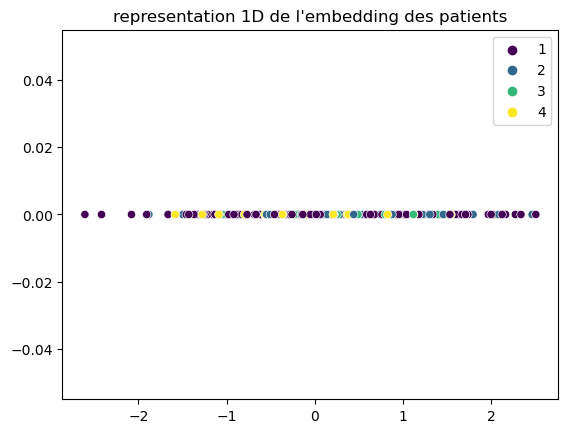

In [30]:
#Visualisation 2D
sns.set_palette("deep") 

# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le docteur
sns.scatterplot( x=patient_embedding_star, y=np.zeros(len(patient_embedding_star),), hue=links_patient, palette='viridis')
plt.title("representation 1D de l'embedding des patients")

plt.show()

### PCA

In [33]:
pca = PCA(n_components=2)
patient_pca = pca.fit_transform(patient_embedding_star)
doctor_pca = pca.fit_transform(doctor_embedding_star)

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

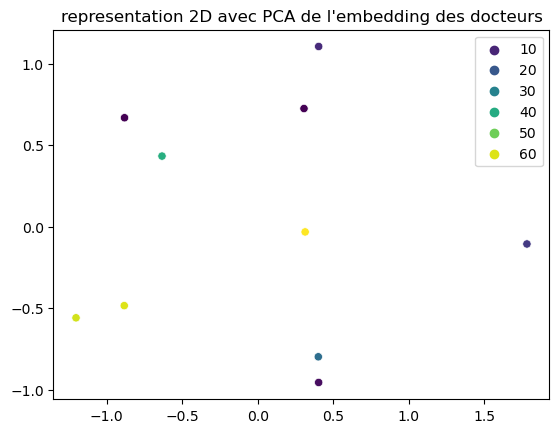

In [32]:
sns.set_palette("deep")
# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le docteur
sns.scatterplot( x=doctor_pca[:,0], y=doctor_pca[:,1], hue=links_doctor, palette='viridis')
plt.title("representation 2D avec PCA de l'embedding des docteurs")

plt.show()

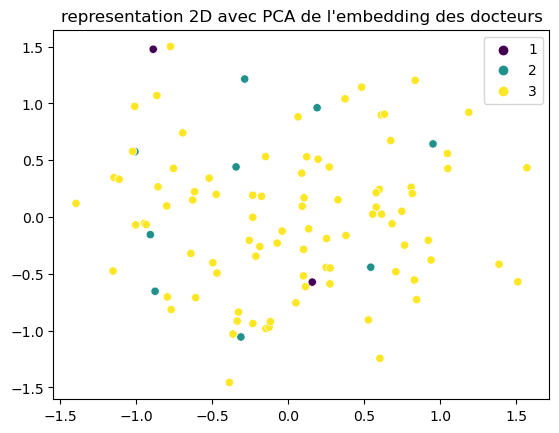

In [34]:
sns.set_palette("deep")
# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le patient 
sns.scatterplot( x=patient_pca[:,0], y=patient_pca[:,1], hue=links_patient, palette='viridis')
plt.title("representation 2D avec PCA de l'embedding des docteurs")

plt.show()

### Umap

On utilise maintenant la méthode UMAP: https://arxiv.org/pdf/1802.03426

In [36]:
# Application de l'algo UMAP sur les embeddings
patient_umap = umap.UMAP(n_components=2, n_neighbors=5, metric='cosine').fit(patient_embedding)
doctor_umap = umap.UMAP(n_components=2,  n_neighbors=5, metric='cosine').fit(doctor_embedding)

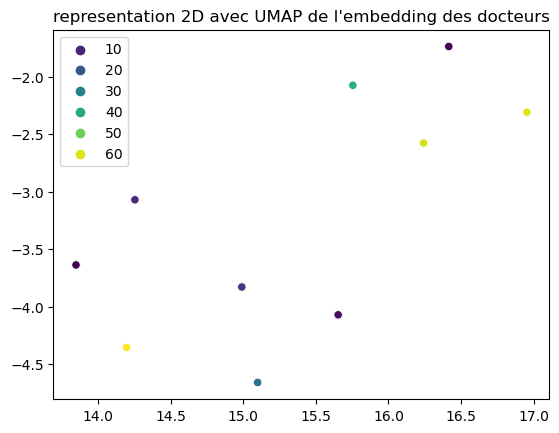

In [37]:
#Visualisation 2D
sns.set_palette("deep") 

# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le docteur
sns.scatterplot( x=doctor_umap.embedding_[:,0], y=doctor_umap.embedding_[:,1], hue=links_doctor, palette='viridis')
plt.title("representation 2D avec UMAP de l'embedding des docteurs")

plt.show()

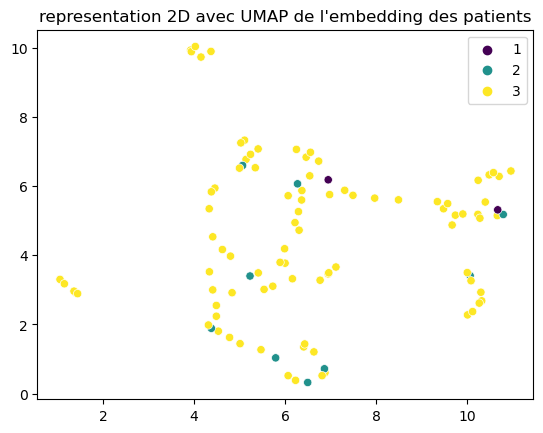

In [43]:
sns.set_palette("deep")

# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le patient
sns.scatterplot( x=patient_umap.embedding_[:,0], y=patient_umap.embedding_[:,1], hue=links_patient, palette='viridis')
plt.title("representation 2D avec UMAP de l'embedding des patients")

plt.show()

## Clustering

### Clustering sur le vrai Embedding

In [32]:
patient_embedding_star = np.array(alpha_graph).flatten()
doctor_embedding_star = np.array(psi_graph).flatten()

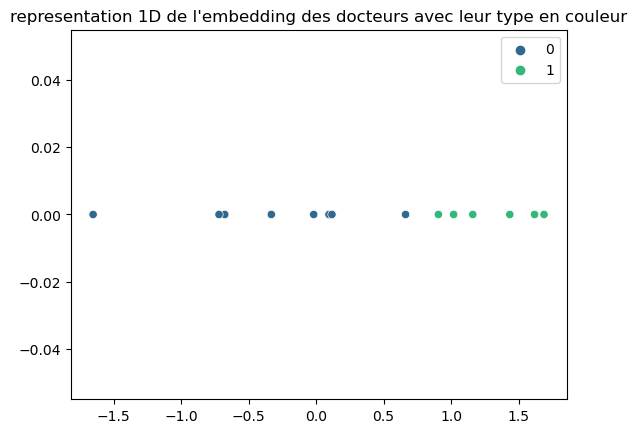

In [34]:
#Visualisation des clusters
sns.set_palette("deep") 

# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le docteur
sns.scatterplot( x= doctor_embedding_star, y= np.zeros(doctor_embedding_star.shape[0],), hue=psi_class, palette='viridis')
plt.title("representation 1D de l'embedding * des docteurs avec leur type en couleur")

plt.show()

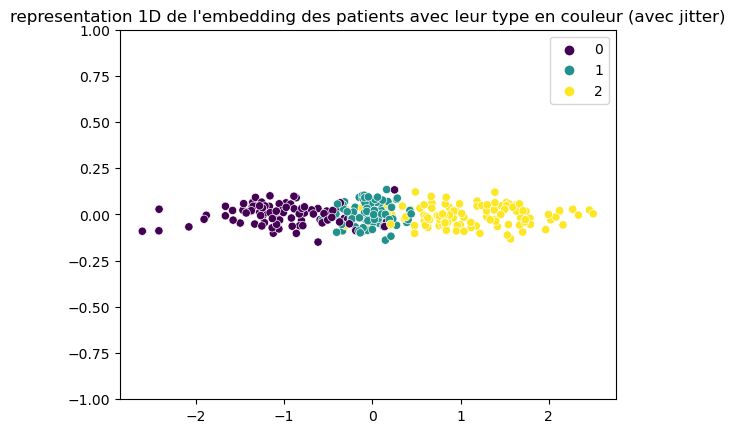

In [36]:
#Visualisation des clusters
sns.set_palette("deep") 

# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le docteur
sns.scatterplot( x= patient_embedding_star, y= np.random.normal(0, 0.05, size=patient_embedding_star.shape[0],), hue=alpha_class, palette='viridis')
plt.title("representation 1D de l'embedding * des patients avec leur type en couleur (avec jitter)")
plt.ylim(-1,1)

plt.show()

#### K-means

In [38]:
# Initialiser le modèle KMeans avec 4 clusters
kmeans_p_star = KMeans(n_clusters=3, random_state=0)
# Ajuster le modèle sur les données
kmeans_p_star.fit(patient_embedding_star.reshape(-1,1))
# Ajouter les labels prédits au DataFrame
cluster_patient_star = kmeans_p_star.labels_

C:\Users\vince\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vince\anaconda3\Lib\site-packages\daal4py\sklearn\cluster\_k_means_0_23.py:184: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


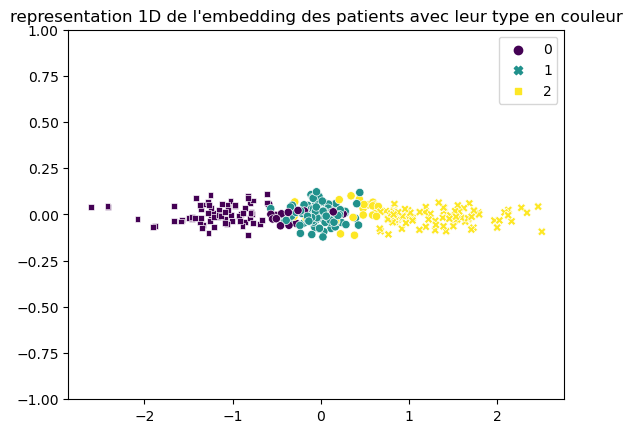

In [40]:
#Visualisation des clusters
sns.set_palette("deep") 

# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le docteur
sns.scatterplot( x= patient_embedding_star, y= np.random.normal(0, 0.05, size=patient_embedding_star.shape[0],), hue=alpha_class, style = cluster_patient_star, palette='viridis')
plt.title("representation 1D de l'embedding des patients avec leur type en couleur et la forme pour le cluster ")
plt.ylim(-1,1)
plt.show()

In [391]:
# Initialiser le modèle KMeans avec 4 clusters
kmeans_d_star = KMeans(n_clusters=2, random_state=1)
# Ajuster le modèle sur les données
kmeans_d_star.fit(doctor_embedding_star.reshape(-1,1))
# Ajouter les labels prédits au DataFrame
cluster_doctor_star = kmeans_d_star.labels_

C:\Users\vince\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\vince\anaconda3\Lib\site-packages\daal4py\sklearn\cluster\_k_means_0_23.py:184: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


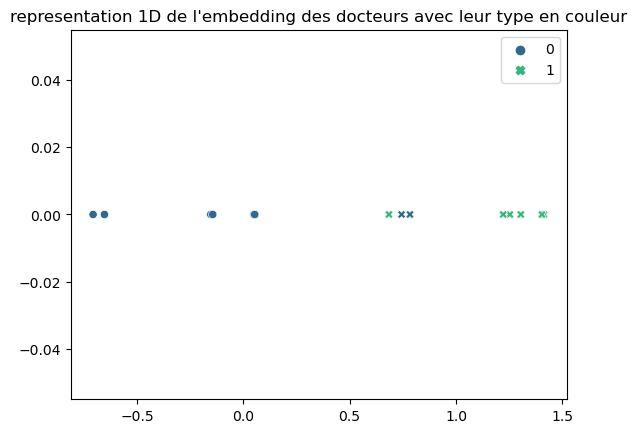

In [393]:
#Visualisation des clusters
sns.set_palette("deep") 

# La couleur représente le degré, c'est-à-dire le nombre de lien qu'a le docteur
sns.scatterplot( x= doctor_embedding_star, y= np.zeros(doctor_embedding_star.shape[0],), hue=psi_class, style=cluster_doctor_star, palette='viridis')
plt.title("representation 1D de l'embedding des docteurs avec leur type en couleur")

plt.show()

### Clustering sur l'Embedding estimé